In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# dataset real: Zuzanna's photo
# Link: https://drive.google.com/drive/folders/1UYo8nV_uKaXUnlsHGz6xkQ9GSZVL-WtC?usp=share_link
# size: large


# fake dataset: stable diffusion v2, generated with random prompts (chatGPT)
# size: 768x768
# Link: https://drive.google.com/drive/folders/1q9scsj0mzq0wCL_kkc6NFugFk_TAvlt2?usp=share_link


In [3]:
# The results for the datasets above, using code : https://github.com/rezashkv/gen-image-detector/blob/main/gradient/grad_metric.py
# results in file: https://drive.google.com/drive/folders/1KjfTc7ym-kUg17AEZxdZt_htgwkj-I6c?usp=share_link

path_1 = '/content/drive/MyDrive/CMSC673/Final_presentation/Data/result_real_photo_Zuzanna_vs_fake_photo'

results_dataset = []
for name in os.listdir(path_1):
  results_dataset.append(name)

In [4]:
i = 0
for i, file_csv in enumerate(results_dataset):
  df1 = pd.read_csv(path_1 + '/' + file_csv)
  new_col_name = file_csv[8:13] + file_csv[13:-4]
  df1 = df1.rename(columns={"errors": new_col_name})
  if i == 0:
    df = df1
  else:
    df = df1.join(df)

In [5]:
df

,fake_75,real_25,fake_100,real_5,real_20,fake_20,fake_50,fake_5,real_75,fake_25,real_100,real_50
0,13586.289062,20090.462891,15397.743164,15721.943359,19358.476562,8899.525391,11803.294922,6511.412109,27597.886719,9296.701172,31117.550781,24452.068359
1,29165.783203,26380.152344,32231.621094,24988.673828,25208.714844,18399.976562,25254.044922,15568.170898,32664.871094,19737.500000,36362.054688,29728.101562
2,19607.406250,21318.105469,22275.285156,22197.859375,20302.763672,11280.412109,16032.881836,9427.036133,25856.150391,12239.917969,28550.074219,23812.480469
3,49764.503906,51987.859375,56717.703125,48876.335938,50541.695312,29809.726562,42158.707031,24988.218750,63521.695312,32371.267578,68048.007812,58534.734375
4,14939.541992,14400.558594,16985.343750,14763.892578,14119.496094,8843.312500,12199.748047,7424.930664,18714.089844,9399.121094,20499.855469,16469.804688
...,...,...,...,...,...,...,...,...,...,...,...,...
145,23937.367188,9085.406250,27947.148438,8780.367188,8788.529297,14081.936523,19869.335938,12676.653320,12680.283203,15044.966797,14891.779297,10869.208008
146,33674.539062,15916.759766,39662.355469,15171.949219,15274.708984,17508.447266,27090.808594,15360.855469,21120.648438,19039.640625,22611.525391,18281.935547
147,3184.520996,21199.341797,3712.098633,19695.728516,20138.759766,1823.652832,2659.247070,1539.151489,28070.523438,1983.139893,31221.400391,24522.248047
148,6923.750977,12690.595703,7974.178711,13238.613281,12317.724609,3816.807617,5653.133789,3722.293457,15516.351562,4183.343750,17135.312500,14084.094727


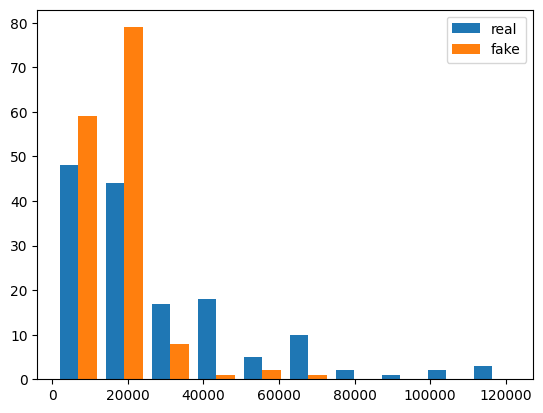

In [6]:
plt.hist([df['real_5'], df['fake_5']])

plt.legend(['real', 'fake'])
plt.show()

In [7]:
bins1 = [*range(0, 90000, 5000)]

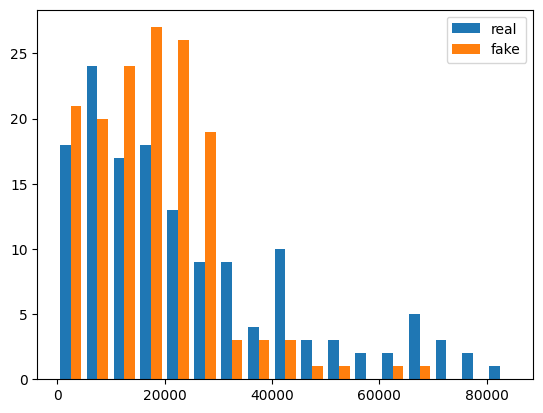

In [8]:
plt.hist([df['real_20'], df['fake_20']], bins=bins1)

plt.legend(['real', 'fake'])
plt.show()

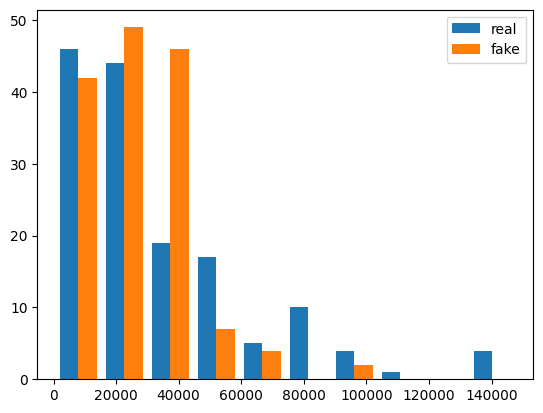

In [9]:
plt.hist([df['real_50'], df['fake_50']])

plt.legend(['real', 'fake'])
plt.show()

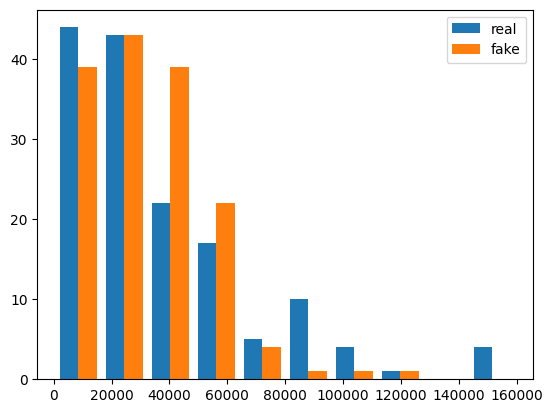

In [10]:
plt.hist([df['real_75'], df['fake_75']])

plt.legend(['real', 'fake'])
plt.show()

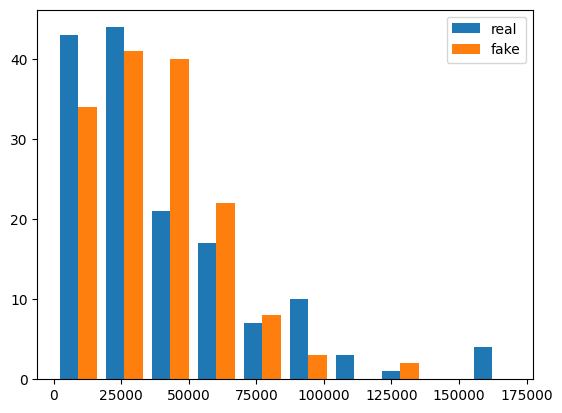

In [11]:
plt.hist([df['real_100'], df['fake_100']])

plt.legend(['real', 'fake'])
plt.show()

In [12]:
## Hard to see anything on the graphs. Next we compare the ratio of L2_error_step_1 / L2_error_step_2

In [13]:
def hypothesis_df (number_1, number_2, df, hypothesis_number):
  df_f = df[[f'fake_{number_1}', f'fake_{number_2}']].copy()
  df_r = df[[f'real_{number_1}', f'real_{number_2}']].copy()
  df_f['actual'] = 1
  df_r['actual'] = 0
  df_f['prediction'] = 0
  df_r['prediction'] = 0
  df_f.loc[df_f[f'fake_{number_1}'] / df_f[f'fake_{number_2}']  <= hypothesis_number, 'prediction'] = 1
  df_r.loc[df_r[f'real_{number_1}'] / df_r[f'real_{number_2}']  <= hypothesis_number, 'prediction'] = 1
  df_hypothesis = pd.concat([df_f, df_r])
  return df_hypothesis

In [14]:
def cf_matrix(number_1, number_2, rate, df):
  df_hypothesis = hypothesis_df (number_1, number_2, df, rate)
  y_test = df_hypothesis['actual']
  y_pred = df_hypothesis['prediction']

  cf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  plt.title(f'Confusion Matrix for threshold {rate}')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

In [15]:
def roc_graph(number_1, number_2, df):
  #roc
  errors_fake = list(df[f'fake_{number_1}'] / df[f'fake_{number_2}'])
  errors_real =  list(df[f'real_{number_1}'] / df[f'real_{number_2}'])
  preds =  errors_fake + errors_real
  preds = [1 - pred for pred in preds]

  t_labels = [1] * len(errors_fake) + [0] * len(errors_real)

  fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds)
  auc = metrics.auc(fpr, tpr)
  acc = np.max(1 - (fpr + (1 - tpr))/2)
  roc_auc = metrics.auc(fpr, tpr)

  err = .01
  low = tpr[np.where(fpr<.01)[0][-1]]

  print(low)
  # method I: plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.02f' % roc_auc)
  plt.plot(low, err, 'b', label = 'FPR@TPR < 0.01 = %0.02f' % low)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

5 20
0.6266666666666667


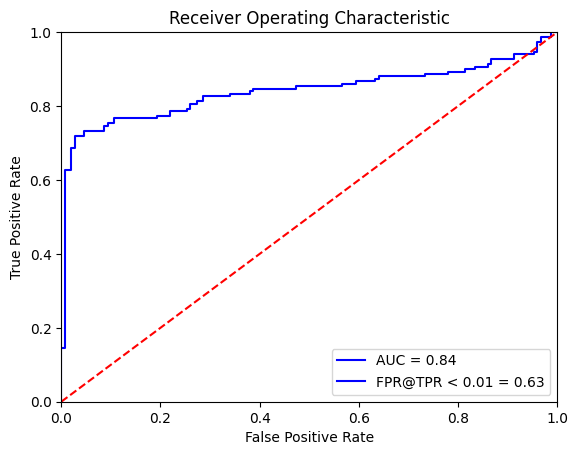

5 25
0.6866666666666666


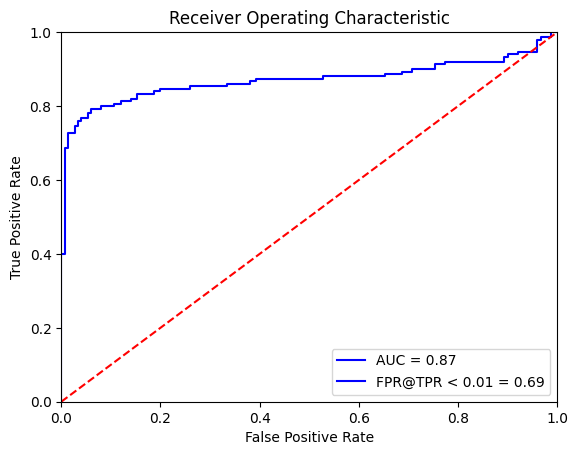

5 50
0.7


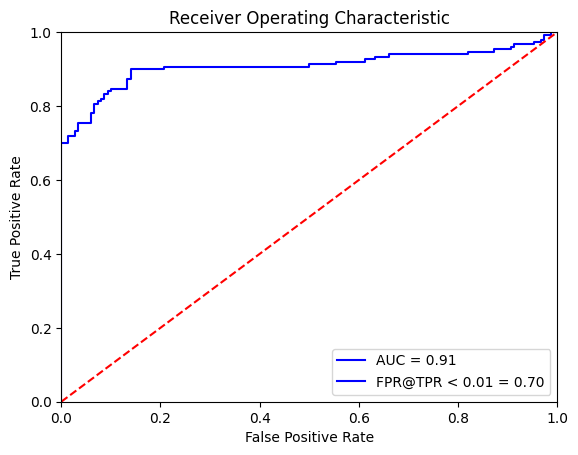

5 75
0.6466666666666666


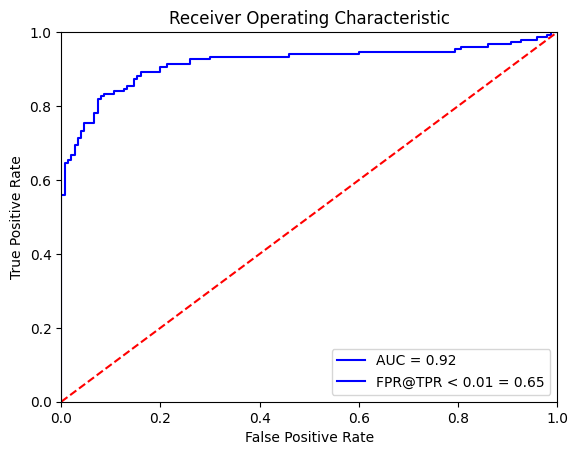

5 100
0.66


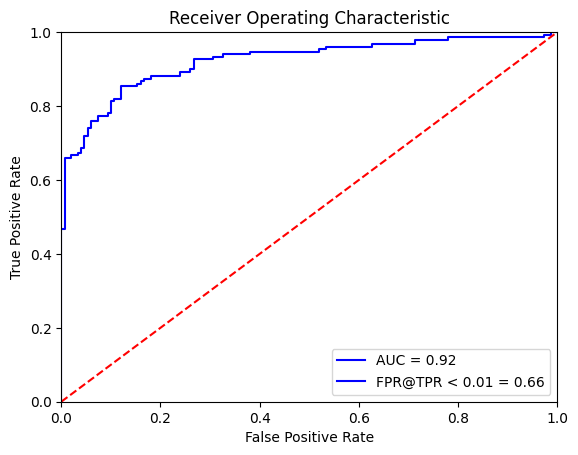

20 25
0.29333333333333333


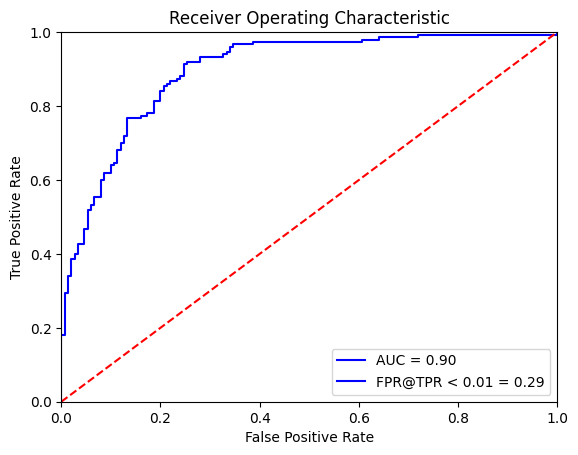

20 50
0.35333333333333333


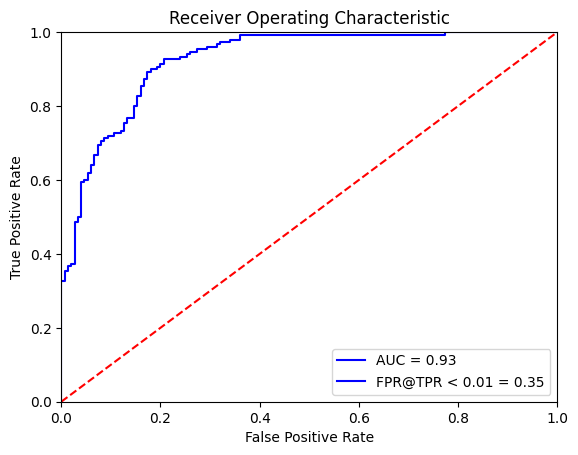

20 75
0.24


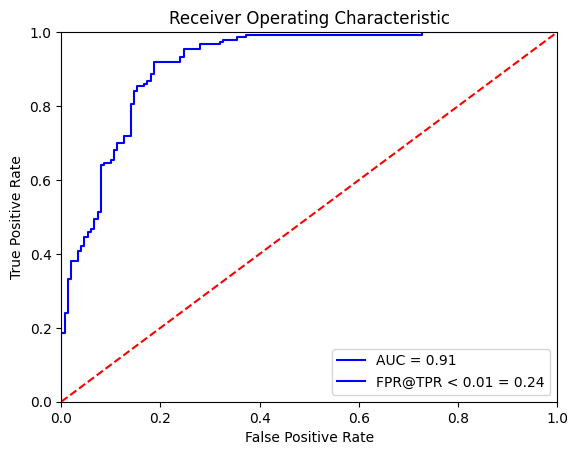

20 100
0.18666666666666668


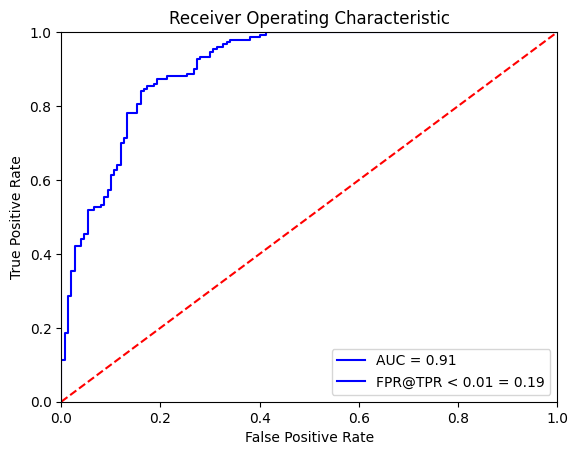

25 50
0.30666666666666664


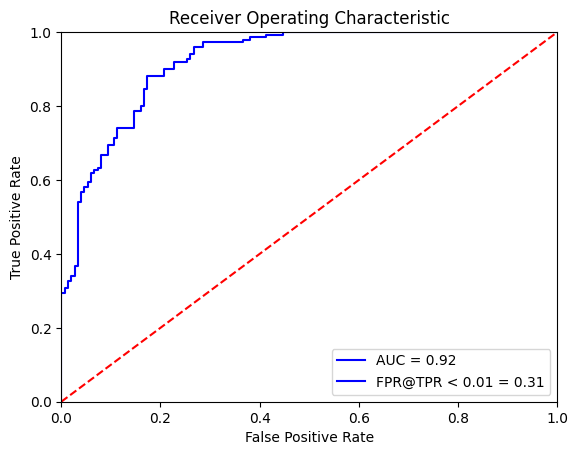

25 75
0.23333333333333334


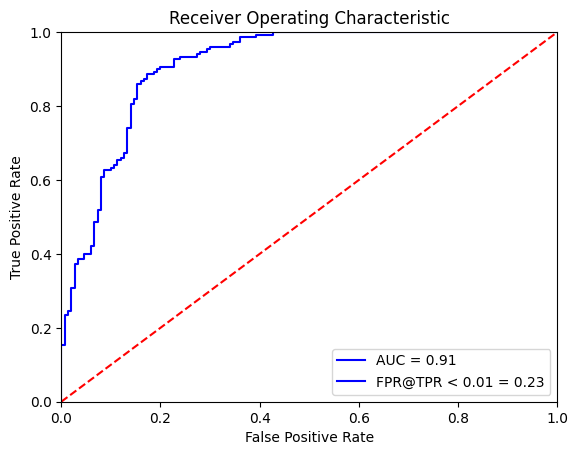

25 100
0.16


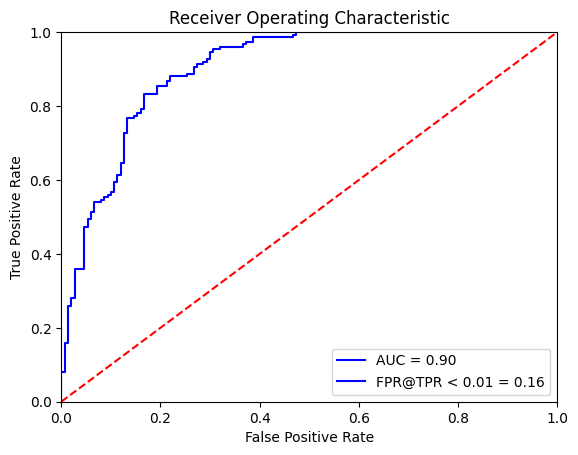

50 75
0.07333333333333333


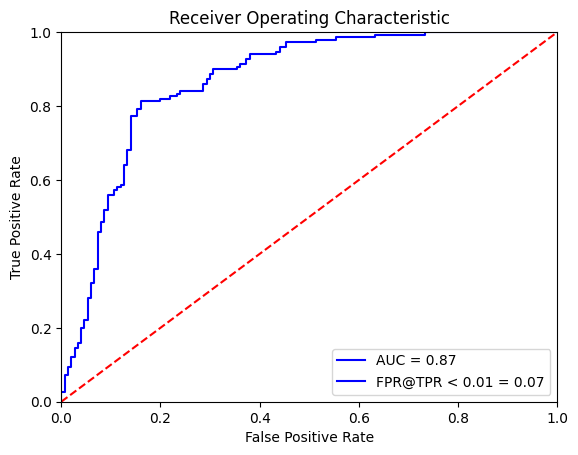

50 100
0.07333333333333333


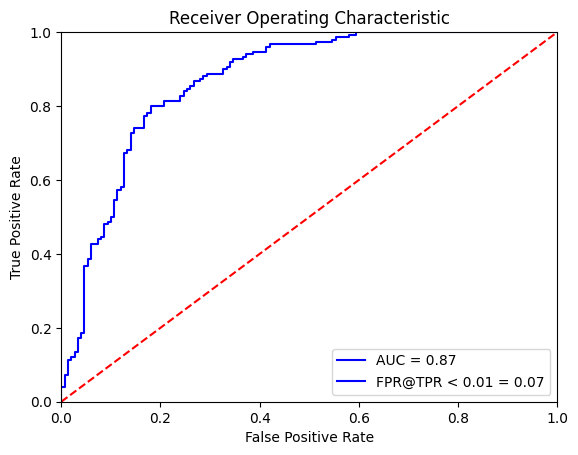

75 100
0.05333333333333334


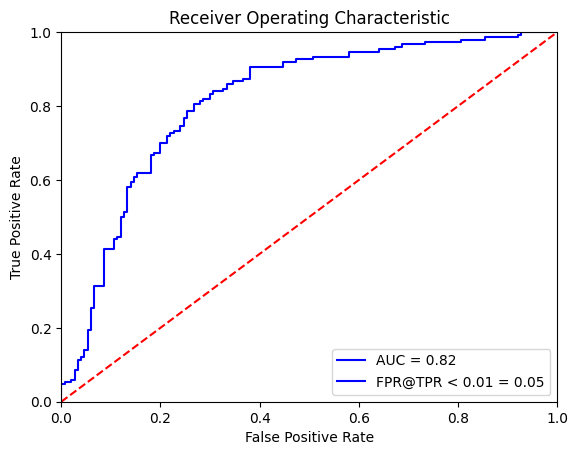

In [16]:
for i in [5,20,25,50,75,100]:
  for j in [20,25,50,75,100]:
    if i < j:
      print(i , j)
      roc_graph(i, j, df)


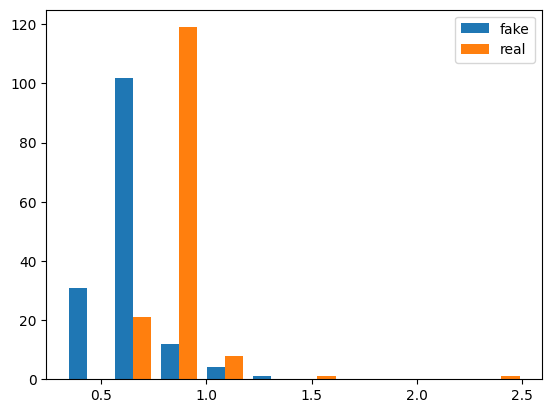

In [23]:
plt.hist([df['fake_5'] / df['fake_50'], df['real_5'] / df['real_50']])

plt.legend(['fake', 'real'])
plt.show()

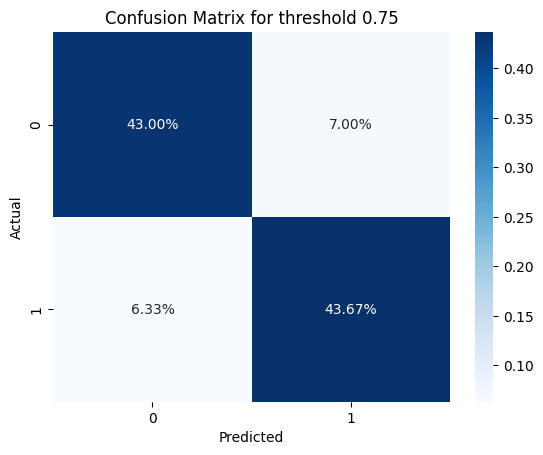

In [18]:
cf_matrix(5, 50, 0.75, df)

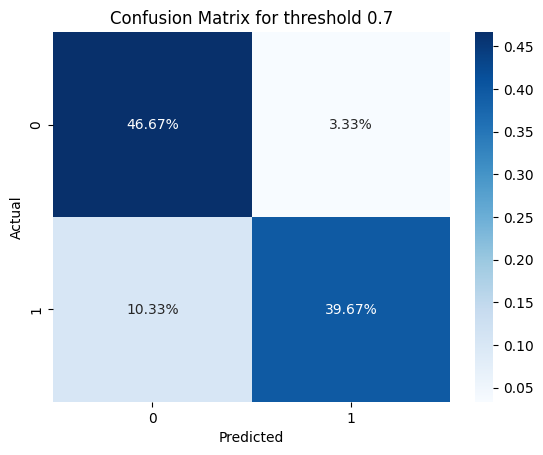

In [19]:
cf_matrix(5, 50, 0.7, df)

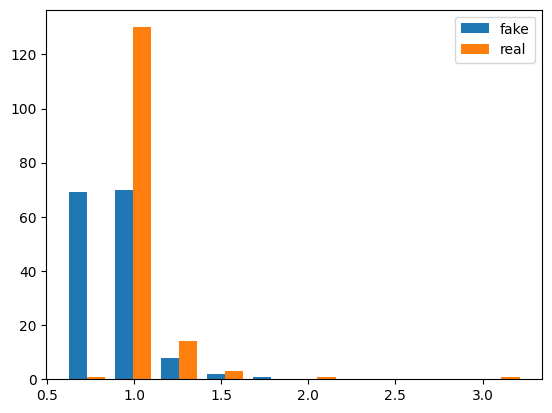

In [20]:
plt.hist([df['fake_5'] / df['fake_20'], df['real_5'] / df['real_20']])

plt.legend(['fake', 'real'])
plt.show()

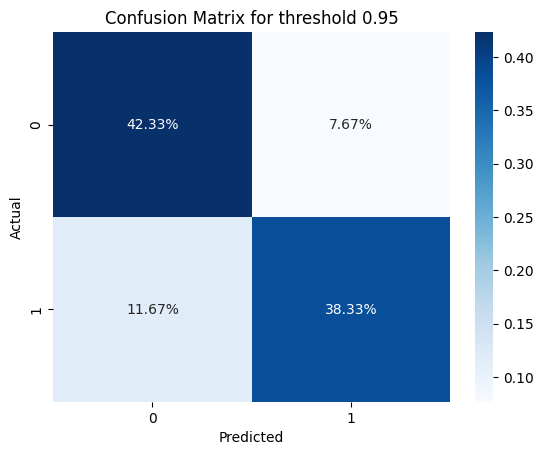

In [21]:
cf_matrix(5, 20, 0.95, df)

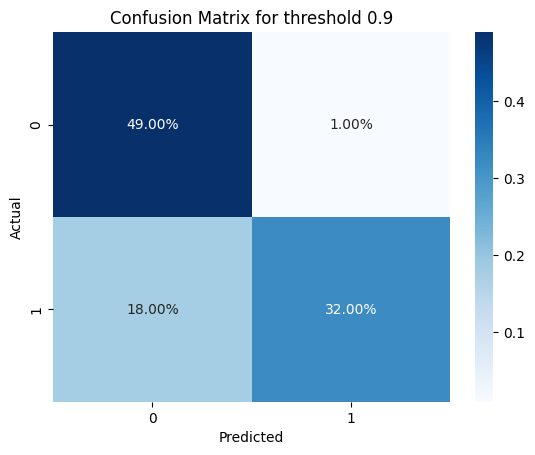

In [22]:
cf_matrix(5, 20, 0.9, df)